# Geospatial Analysis — Italian Restaurants in Manhattan

Mapping restaurant density by neighborhood, identifying underserved areas, and supporting the location recommendation for the flagship store.

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point
import requests

# Plot style
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["figure.dpi"] = 100

# Color palette
CATEGORY_COLORS = {"Pizzeria": "red", "Restaurant": "blue", "Panini": "orange", "Street Food": "green"}
CATEGORY_ICONS = {"Pizzeria": "pizza-slice", "Restaurant": "utensils", "Panini": "bread-slice", "Street Food": "hamburger"}

In [7]:
# Load dataset
df = pd.read_csv("../data/nyc_italian_restaurants.csv")

# Drop unnecessary columns & rename
cols_to_drop = [c for c in ["Name", "Latitude", "Longitude", "Case"] if c in df.columns]
df = df.drop(columns=cols_to_drop).rename(columns={"C": "Category"})

# Keep only rows with valid coordinates
df = df.dropna(subset=["latitude", "longitude"])
print(f"Restaurants with valid coordinates: {len(df)}")
df.head()

Restaurants with valid coordinates: 172


,Restaurant,Price,Food,Decor,Service,East,latitude,longitude,Category
0,Daniella Ristorante,43,22,18,20,0,40.746831,-73.996758,Pizzeria
1,Tello's Ristorante,32,20,19,19,0,40.743421,-73.999537,Panini
2,Biricchino,34,21,13,18,0,40.748864,-73.995519,Street Food
3,Bottino,41,20,20,17,0,40.748485,-74.003313,Pizzeria
4,Da Umberto,54,24,19,21,0,40.739581,-73.995910,Pizzeria


## 2. Load NYC Neighborhood Boundaries

In [6]:
# Load Manhattan neighborhood boundaries from local file
gdf_manhattan = gpd.read_file("../data/nyc_neighborhoods.geojson")

# Rename 'name' to 'neighborhood' to match the rest of the notebook
gdf_manhattan = gdf_manhattan.rename(columns={"name": "neighborhood"})

print(f"Manhattan neighborhoods loaded: {len(gdf_manhattan)}")
print(gdf_manhattan['neighborhood'].tolist())


Manhattan neighborhoods loaded: 37
['Battery Park City', 'Central Park', 'Chelsea', 'Chinatown', 'Civic Center', 'East Harlem', 'East Village', 'Ellis Island', 'Financial District', 'Flatiron District', 'Governors Island', 'Gramercy', 'Greenwich Village', 'Harlem', "Hell's Kitchen", 'Inwood', 'Kips Bay', 'Liberty Island', 'Little Italy', 'Lower East Side', 'Marble Hill', 'Midtown', 'Morningside Heights', 'Murray Hill', 'NoHo', 'Nolita', "Randall's Island", 'Roosevelt Island', 'SoHo', 'Stuyvesant Town', 'Theater District', 'Tribeca', 'Two Bridges', 'Upper East Side', 'Upper West Side', 'Washington Heights', 'West Village']


## 3. Spatial Join — Assign Restaurants to Neighborhoods

In [8]:
# Convert restaurants to GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(df["longitude"], df["latitude"])]
gdf_restaurants = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Spatial join: which neighborhood is each restaurant in?
gdf_joined = gpd.sjoin(gdf_restaurants, gdf_manhattan, how="left", predicate="within")

# Count restaurants per neighborhood
neighborhood_counts = (
    gdf_joined.groupby("neighborhood")
    .size()
    .reset_index(name="n_restaurants")
    .sort_values("n_restaurants", ascending=False)
)

print("Restaurants per neighborhood:")
print(neighborhood_counts.to_string(index=False))

Restaurants per neighborhood:
      neighborhood  n_restaurants
   Upper East Side             55
           Midtown             40
    Hell's Kitchen             15
   Upper West Side             15
           Chelsea             11
  Theater District              9
       Murray Hill              6
          Gramercy              4
              SoHo              4
 Greenwich Village              3
          Kips Bay              3
       East Harlem              2
 Flatiron District              2
Financial District              1
      East Village              1
      West Village              1


## 4. Restaurant Density Map

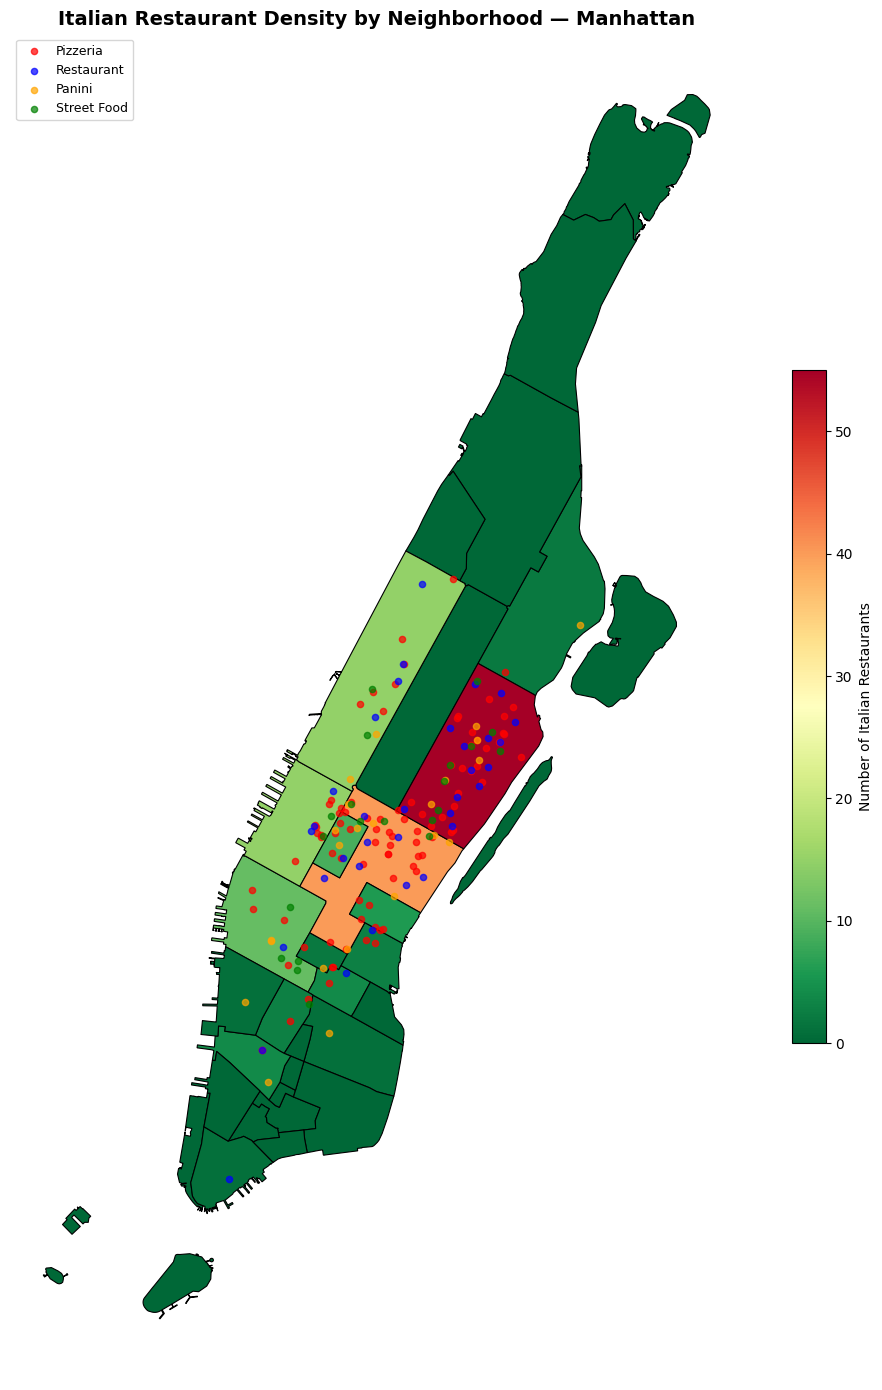

In [9]:
# Merge counts into neighborhood geodataframe
gdf_density = gdf_manhattan.merge(neighborhood_counts, on="neighborhood", how="left")
gdf_density["n_restaurants"] = gdf_density["n_restaurants"].fillna(0).astype(int)

# Plot density choropleth
fig, ax = plt.subplots(figsize=(10, 14))
gdf_density.plot(
    column="n_restaurants", cmap="RdYlGn_r", linewidth=0.8,
    edgecolor="black", legend=True, ax=ax,
    legend_kwds={"label": "Number of Italian Restaurants", "shrink": 0.5}
)

# Overlay restaurant points
for cat, color in CATEGORY_COLORS.items():
    subset = gdf_joined[gdf_joined["Category"] == cat]
    ax.scatter(subset.geometry.x, subset.geometry.y, c=color, s=20, label=cat, alpha=0.7, zorder=5)

ax.set_title("Italian Restaurant Density by Neighborhood — Manhattan", fontsize=14, fontweight="bold")
ax.legend(loc="upper left", fontsize=9)
ax.axis("off")
plt.tight_layout()
plt.show()

## 5. Neighborhood Ranking — Bar Chart

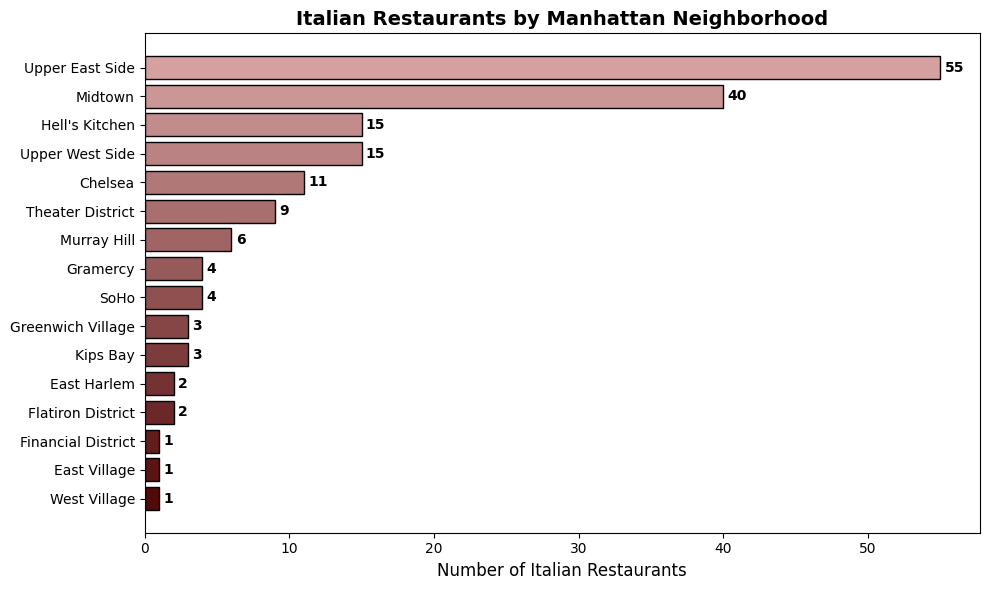


SoHo has only 4 Italian restaurants — one of the least saturated areas.


In [10]:
# Bar chart of restaurants per neighborhood
from matplotlib.colors import LinearSegmentedColormap

top_n = neighborhood_counts.head(16)
cmap = LinearSegmentedColormap.from_list("reds", ["#D4A0A0", "#4A0000"])
colors = [cmap(i / len(top_n)) for i in range(len(top_n))]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_n["neighborhood"][::-1], top_n["n_restaurants"][::-1], color=colors[::-1], edgecolor="black")

for bar, val in zip(bars, top_n["n_restaurants"][::-1]):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            str(val), va="center", fontsize=10, fontweight="bold")

ax.set_xlabel("Number of Italian Restaurants", fontsize=12)
ax.set_title("Italian Restaurants by Manhattan Neighborhood", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Highlight SoHo
soho_count = neighborhood_counts[neighborhood_counts["neighborhood"] == "SoHo"]["n_restaurants"].values
if len(soho_count) > 0:
    print(f"\nSoHo has only {soho_count[0]} Italian restaurants — one of the least saturated areas.")

## 6. Interactive Map with Folium

In [13]:
import os

# Create interactive map
m = folium.Map(location=[40.76, -73.98], zoom_start=13, tiles="CartoDB Positron")

# Add neighborhood density as choropleth
geo_data = gdf_density[["neighborhood", "n_restaurants", "geometry"]].to_json()

folium.Choropleth(
    geo_data=geo_data,
    data=gdf_density,
    columns=["neighborhood", "n_restaurants"],
    key_on="feature.properties.neighborhood",
    fill_color="RdYlGn_r",
    fill_opacity=0.5,
    line_opacity=0.8,
    legend_name="Number of Italian Restaurants"
).add_to(m)

# Add restaurant markers
for _, row in gdf_joined.iterrows():
    cat = row["Category"]
    color = CATEGORY_COLORS.get(cat, "gray")
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"{row['Restaurant']} ({cat}) - ${row['Price']}"
    ).add_to(m)

# Save and display
os.makedirs("../docs", exist_ok=True)
m.save("../docs/manhattan_restaurants_map.html")
print("Interactive map saved to docs/manhattan_restaurants_map.html")
m


Interactive map saved to docs/manhattan_restaurants_map.html


## 7. Category Breakdown by Neighborhood

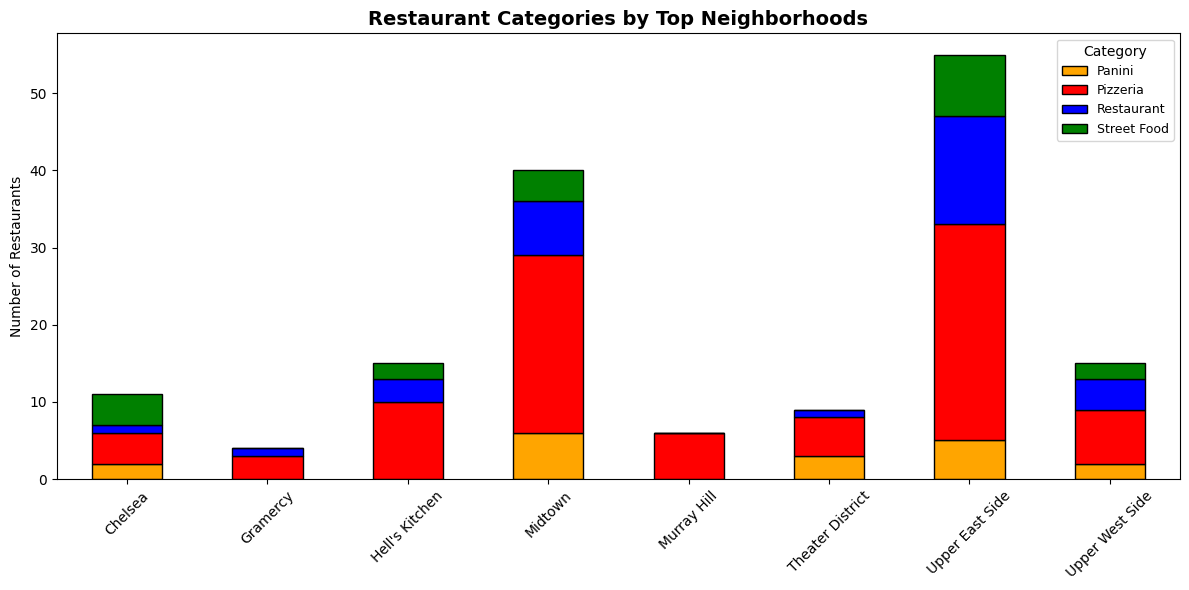

In [14]:
# Category distribution per neighborhood
cat_by_hood = (
    gdf_joined.groupby(["neighborhood", "Category"])
    .size()
    .unstack(fill_value=0)
)

# Show top neighborhoods
top_hoods = neighborhood_counts.head(8)["neighborhood"].tolist()
cat_subset = cat_by_hood.loc[cat_by_hood.index.isin(top_hoods)]

fig, ax = plt.subplots(figsize=(12, 6))
cat_subset.plot(kind="bar", stacked=True, ax=ax,
                color=[CATEGORY_COLORS.get(c, "#999") for c in cat_subset.columns],
                edgecolor="black")
ax.set_title("Restaurant Categories by Top Neighborhoods", fontsize=14, fontweight="bold")
ax.set_ylabel("Number of Restaurants")
ax.set_xlabel("")
ax.tick_params(axis="x", rotation=45)
ax.legend(title="Category", fontsize=9)
plt.tight_layout()
plt.show()

## 8. Key Findings

1. **Upper East Side** (55) and **Midtown** (40) dominate the Italian restaurant scene
2. **SoHo has only 4 Italian restaurants** — making it one of the least saturated areas
3. The southern half of Manhattan is significantly underserved compared to the north
4. SoHo combines low competition with high foot traffic, affluent demographics, and a lifestyle-oriented customer base
5. **Recommendation**: SoHo is the optimal location for the flagship store, offering visibility and differentiation in an underserved market